<h1 style="font-family: 'Cooper'">
SimpleOCR
</h1>

<h2 style="font-family: 'Cooper'">
Import necessary package
<h2>

In [1]:
import string
import numpy as np
from IPython.display import display

import torch
from torch import nn
import torch.optim as optim
from torchvision.transforms import v2
from trdg.generators import GeneratorFromRandom

# local file
import ocr_batch_functions
import ocr_visualization

Missing modules for handwritten text generation.


<h2 style="font-family: 'Cooper'"> 
Define the OCR model
<h2>

In [2]:
class OCR(nn.Module):
    @staticmethod
    def CNNBlock(c, k):
        """
        c: out_channel
        k: kernel_size
        the input tensor's shape is [batch_size, nums_features, height, width]
        the output tensor's features will be unified to c, shape is [batch_size, c, height, width]
        """
        return nn.Sequential(
            nn.LazyConv2d(out_channels=c, kernel_size=k, padding=(k-1)//2),  # Zero-Padding
            nn.BatchNorm2d(c),
            nn.ReLU()
        )
    def __init__(self, numChars, outputSize, hiddenSize, numLayers):
        """
        numChars: the number of characters that the network must learn to recognize
        outputSize: the size of the features that the convolutional sub-network will pass into the RNN
        hiddenSize: the dimensionality of RNN hidden state vectors
        numLayers: the number of layers in the RNN
        """
        super().__init__()
        self.numChars = numChars
        self.outputSize = outputSize
        self.hiddenSize = hiddenSize
        self.numLayers = numLayers
        self.relu = nn.ReLU()
        self.cnnsubset = nn.Sequential(
            self.CNNBlock(8, 3),
            self.CNNBlock(16, 3),
            nn.MaxPool2d(2),
            self.CNNBlock(32, 3),
            self.CNNBlock(64, 3),
            nn.MaxPool2d(2)
        )
        self.denselayer = nn.Linear(512, outputSize)  # 512 is 64 * 8
        self.bidirectionallstm = nn.LSTM(outputSize, hiddenSize, numLayers, batch_first=True, bidirectional=True)
        self.logitlayer = nn.Linear(2 * hiddenSize, numChars + 1)

    def forward(self, x):
        # x is the images that inputed, with shape [batch_size, channel_size, height, width]
        batch_size, _, _, width = x.size()
        x = self.cnnsubset(x).reshape(batch_size, 512, width//4).transpose(1,2)
        x = self.relu(self.denselayer(x))
        o, _ = self.bidirectionallstm(x)  # Discard the result of the last time step in the RNN.
        p = self.logitlayer(o).transpose(0,1)
        result = torch.nn.functional.log_softmax(p, dim=-1) # shape is [T, batch_size, numChars+1]
        return result

<h2 style="font-family: 'Cooper'"> 
Train the OCR model
</h2>

<div style="font-family: 'Consolas'">
    Generate the custom training and validation DataLoaders that use TRDG.
</div>

In [3]:
# Copy from CSCI6962/4140 HW5
allChars = string.digits
charsToLabelsDict = dict((char, ind + 1) for ind, char in enumerate(allChars))  # The string "0" is numbered as 1.
labelsToCharsDict = dict((ind + 1, char) for ind, char in enumerate(allChars))

# BaseGenerator
trdgGenerator = GeneratorFromRandom(
    use_symbols=False,
    use_letters=False,
    background_type=1
)

transforms = v2.Compose([
    v2.PILToTensor(),  # Convert PIL image to tensor
    v2.RandomAffine(degrees=2.0, translate=(0.04, 0.15), shear=4.0),
    v2.ToDtype(torch.float32),  # Normalize expects float input
    v2.Normalize(
        mean=[255 * 0.485, 255 * 0.456, 255 * 0.406],
        std=[255 * 0.229, 255 * 0.224, 255 * 0.225]
    ),
])

epochSize = 10  # the number of minibatches per epoch
batchSize = 100
height = 32

dgParams = {
    "epochSize": epochSize,
    "batchSize": batchSize,
    "height": height,
    "transform": transforms,
    "char_to_lbl_dict": charsToLabelsDict
}

"""
trainGenerator returns X, targets, targetLengths, inputLengths
valGenerator returns images, X, targets, targetLengths, inputLengths

images        :  the sequence of raw images generated by trdg in this minibatch (batch_size, PIL.Image)
X             :  the tensor formed by converting the images to tensors; has shape (batch_size, channel, height, wight)
targets       :  the tensor containing the character sequences corresponding to each image; 
targetLengths :  this has shape (batch_size, `max), where `max is the length of the longest character sequence in the minibatch; 
                 the other character sequences are padded to that length.
inputLengths  :  this tensor contains the true length of each character sequence in the minibatch, and has shape batch_size.
"""
trainGenerator = ocr_batch_functions.OCR_generator(trdgGenerator, **dgParams)
valGenerator = ocr_batch_functions.OCR_generator(trdgGenerator, **dgParams, isValidation=True)

<div style="font-family: 'Consolas'">
Use valGenerator to create 10 example input images, and display them in a 10 row array.
</div>

In [4]:
# images = next(valGenerator)[0]  # get the first minibatch
# for image in images[:10]:
#     display(image)

<div style="font-family: 'Consolas'">
Create model, an instance of the OCR class. Take an appropriate numChars, outputSize = 128, hiddenSize = 64, and numLayers = 4
</div>

In [5]:
ocr_model = OCR(numChars=10, outputSize=128, hiddenSize=64, numLayers=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to GPU if available
ocr_model.to(device)

# test the model
# x = torch.randn(7, 3, 32, 128)  # batch_size, channel_size, height, width
# ocr_model(x).shape  # T, batch_size, numChars+1

OCR(
  (relu): ReLU()
  (cnnsubset): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (

<div style="font-family: 'Consolas'">
Create an ADAM optimizer for training model, using initial global <strong>learning rate lr=5e-3</strong>.
Control the stepsize of the optimizer by using a learning rate scheduler to reduce the global learning rate by 1/2 after every 50 optimization steps; use <strong>torch.optim.lr_scheduler.StepLR</strong> to accomplish this.
</div>

In [6]:
initial_lr = 5e-3
optimizer = optim.Adam(ocr_model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

<div style="font-family: 'Consolas'">
Write standard training functions train_epoch(dataGenerator, model, optimizer, reportInterval=1) and validate(dataGenerator, model). 
The training function should print out the current minibatch loss every reportInterval minibatches. 
The validation function should accumulate the CTCLoss over the entire validation set, and print and return this accumulated loss divided by the number of minibatches in that epoch.
</div>
<div style="font-family: 'Consolas'">
Inside of these training functions, you must check when an epoch has ended and break out of the loop enumerating over the DataLoaders, as they do not automatically end themselves at the end of an epoch. You can do so by checking batchnum == len(dataGenerator), where batchnum is the index of the current minibatch.
</div>

<div style="font-family: Consolas">
    <strong>Note that:</strong> trainGenerator and varGenerator do not implement the logic to raise a StopIteration exception in the __next__() method. The iterators will not terminate normally.
</div>

In [7]:
def train_epoch(dataGenerator, model, optimizer, reportInterval=1):
    model.train()
    total_loss = 0
    total_samples = 0
    for batchnum, (X, targets, targetLengths, inputLengths) in enumerate(dataGenerator):
        optimizer.zero_grad()
        output = model(X.to(device))
        loss = nn.CTCLoss(blank=0, reduction="sum")(output, targets, inputLengths, targetLengths)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        total_loss += loss
        total_samples += len(inputLengths)
        if (batchnum + 1) % reportInterval == 0:
            print(f"Batch {batchnum + 1}, Loss: {loss}, average loss {total_loss / total_samples}")
        if batchnum == len(dataGenerator) - 1:
            break

In [8]:
def validate(dataGenerator, model):
    model.eval()
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for batchnum, (originalImages, X, targets, targetLengths, inputLengths) in enumerate(dataGenerator):
            output = model(X.to(device))
            loss = nn.CTCLoss(blank=0, reduction="sum")(output, targets, inputLengths, targetLengths)
            total_loss += loss.item()
            total_samples += len(inputLengths)

            if batchnum == len(dataGenerator) - 1:
                break
    
    average_loss = total_loss / total_samples
    print("Total loss:", total_loss)
    print("Validation loss:", average_loss)
    return average_loss

<div style="font-family: 'Consolas'">
Set epochs=300 Train the model using the following code to periodically report its
performance and to save the best performing model.
</div>

In [9]:
epochs = 300
losses = [] # store the validation losses during training
bestIndex = 0

bestLoss = np.inf
for t in range(epochs):
    print(f"Epoch {t+1}, lr={scheduler.get_last_lr()}\n-----------------------")
    ocr_model.train()
    train_epoch(trainGenerator, ocr_model, optimizer)
    ocr_model.eval()
    valLoss = validate(valGenerator, ocr_model)
    losses.append(valLoss)
    if valLoss < bestLoss:
        bestIndex = t
        bestLoss = valLoss

    ocr_visualization.visualize_text(ocr_model, valGenerator, allChars, labelsToCharsDict, device=device) # helper function
    scheduler.step()

ocr_model.eval()
print("Done Training!")

Epoch 1, lr=[0.005]
-----------------------
Batch 1, Loss: 8020.2666015625, average loss 80.202666015625
Batch 2, Loss: 6349.8505859375, average loss 71.8505859375
Batch 3, Loss: 2844.9990234375, average loss 57.383720703125
Batch 4, Loss: 1672.936767578125, average loss 47.220132446289064
Batch 5, Loss: 2203.06005859375, average loss 42.18222607421875
Batch 6, Loss: 1967.20361328125, average loss 38.430527750651045
Batch 7, Loss: 2115.9140625, average loss 35.96318673270089
Batch 8, Loss: 1809.6080322265625, average loss 33.72979843139648
Batch 9, Loss: 1662.2576904296875, average loss 31.828996039496527
Batch 10, Loss: 1646.127197265625, average loss 30.2922236328125
Total loss: 17579.650390625
Validation loss: 17.579650390625
Examples:
	Input: 21	Prediction: 3
	Input: 76206	Prediction: 3
Epoch 2, lr=[0.005]
-----------------------
Batch 1, Loss: 1620.703857421875, average loss 16.20703857421875
Batch 2, Loss: 1690.470947265625, average loss 16.5558740234375
Batch 3, Loss: 1740.72192

<div style="font-family: 'Consolas'">
Save the model.
</div>

In [10]:
# torch.save(ocr_model.state_dict(), "ocr_model_weights.pth")
# torch.save(ocr_model, "ocr_model.pth")

<h2 style="font-family: 'Cooper'"> 
Visualize the performance of the trained model
</h2>

<div style="font-family: 'Consolas'">
In an appropriately labeled graph, plot the average validation loss (the quantity returned by the validation function) as a function of the number of epochs of training. For more meaningful visualization, only show results on the last 150 training epochs.
</div>


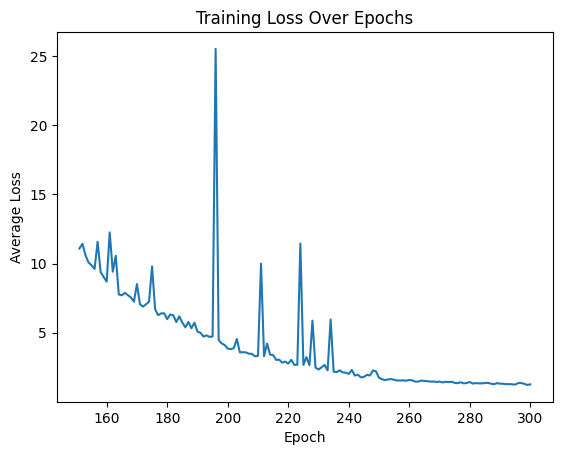

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

x = range(151,301)  # the last 150 training epochs.
losses = losses[150:]
sns.lineplot(x=x, y=losses)

plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')

plt.show()

<div style="font-family: 'Consolas'">
Visualize the output of the best model on 10 example inputs from the validation generator, using ocr_visualization.visualize_image.
</div>

,image,ground truth,recovered label
0,,21,21
1,,76206,1321019
2,,413,413
3,,398,398
4,,6462577411,6462577411
5,,046,046
6,,116,116
7,,287807,287807
8,,298438,298438
9,,4563808452,4563808452

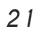
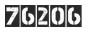
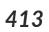
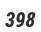
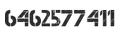
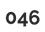
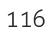
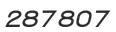
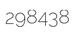
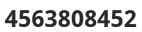

In [12]:
# # I have shut down the kernel, but I did not clear the training logs.
# ocr_model.load_state_dict(torch.load('ocr_model_weights.pth', weights_only=True))
ocr_visualization.visualize_image(ocr_model, valGenerator, allChars, labelsToCharsDict, device=device)